In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys

In [3]:
sys.path.append(r'/Users/alexandershubert/git/statslib')

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
import statslib as stb

In [6]:
import statslib._pathmap

In [7]:
pa = stb.utils.common.print_attributes
ddff = stb.utils.dframe.display_full_df

In [8]:
figsize = (8*1.6, 8)

In [9]:
path = '/Users/alexandershubert/git/statslib/tests/data/df.csv'
df = pd.read_csv(path);
df = stb.utils.dframe.to_pd_todatetime(df, 'day', day_only=False)
y = df.set_index('day').squeeze().rename('y')

In [10]:
path = '/Users/alexandershubert/git/statslib/tests/data/x.csv'
df = pd.read_csv(path);
df = stb.utils.dframe.to_pd_todatetime(df, 'day', day_only=False)
X = df.set_index('day')

***

## Percentage Change: 
$$
f(y_t, n) = \frac{y_t - y_{t-n}}{y_{t-n}} = v_t
$$

In [159]:
periods = 5

f = stb.transforms.pct_change(periods=periods)

v = f(y)

pd.concat([y, f(y), f.inv(v), f.inv(v,y.iloc[:periods].values.tolist(), y.index)], axis=1).head(periods+1)

,y,v,y_hat,y_hat
day,,,,
2018-12-18,67.989998,NaN,67.989998,67.989998
2018-12-19,66.830002,NaN,66.830002,66.830002
2018-12-20,65.190002,NaN,65.190002,65.190002
2018-12-21,63.290001,NaN,63.290001,63.290001
2018-12-24,62.669998,NaN,62.669998,62.669998
2018-12-26,65.540001,-0.036035,65.540001,65.540001


***

## Log Return:
$$
f(y_t, n) = \log\left(\frac{y_t}{y_{t-n}}\right) = v_t
$$

In [160]:
periods = 5

f = stb.transforms.log_return(periods=periods)

v = f(y)

pd.concat([y, f(y), f.inv(v), f.inv(v,y.iloc[:periods].values.tolist(), y.index)], axis=1).head(periods+1)

,y,v,y_hat,y_hat
day,,,,
2018-12-18,67.989998,NaN,67.989998,67.989998
2018-12-19,66.830002,NaN,66.830002,66.830002
2018-12-20,65.190002,NaN,65.190002,65.190002
2018-12-21,63.290001,NaN,63.290001,63.290001
2018-12-24,62.669998,NaN,62.669998,62.669998
2018-12-26,65.540001,-0.0367,65.540001,65.540001


# Difference operator:

$$
f(y_t) = \nabla^d\nabla_s^D(y_t) = (1-L)^d (1-L_s)^D y_t = \sum_{i=0}^d(-1)^{i}\binom{n}{i}\sum_{j=0}^D(-1)^{j}\binom{n}{j}y_{(t-s)-j-i} = v_t
$$

In [161]:
f = stb.transforms.difference_operator(1,1,7, inv_specification=[[-1,-1,1],[1,7,8]])

f = stb.transforms.difference_operator(2,1,7, inv_specification=[[-2,1,-1,2,-1], [1,2,7,8,9]])

f = stb.transforms.difference_operator(2,None,0, inv_specification=[[-2,1],[1,2]])

f = stb.transforms.difference_operator(1,1,3, inv_specification=[[-1,-1,1],[1,3,4]])

f = stb.transforms.difference_operator(2,1,3, inv_specification=[[-2,1,-1,2,-1],[1,2,3,4,5]])

In [162]:
ddff(pd.concat([y, f(y), f.inv(f(y))], axis=1).head(f.n+4))

,y,v,y_hat
day,,,
2018-12-18,67.989998,NaN,67.989998
2018-12-19,66.830002,NaN,66.830002
2018-12-20,65.190002,NaN,65.190002
2018-12-21,63.290001,NaN,63.290001
2018-12-24,62.669998,NaN,62.669998
2018-12-26,65.540001,3.970009,65.540001
2018-12-27,66.480003,-1.669998,66.480003
2018-12-28,65.959999,-2.740005,65.959999
2018-12-31,67.459999,-1.470001,67.459999


### Simulation

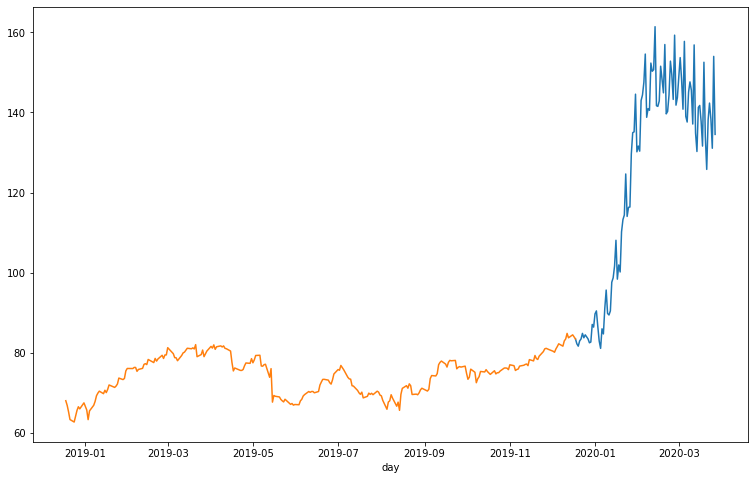

In [163]:
import random
from datetime import date

#(1,1,7)
f = stb.transforms.difference_operator(2,1,7, inv_specification=[[-1,-1,1],[1,7,8]])

periods=100

idx = pd.date_range(start=date(2019,12,19), periods=periods, freq='D')
idx = pd.DatetimeIndex(idx)

v_hat = pd.Series([random.uniform(-4,4) for i in range(periods)], index=idx).rename('v_hat');

y0=y.iloc[-f.n:]

fig, ax = plt.subplots(figsize=figsize)
y_hat = f.inv(v_hat, y0, idx)
y_hat.index = [t.date() for t in y_hat.index]
y_hat[y.index.max()]=y[y.index.max()]
y_hat.sort_index(inplace=True)
y_hat.plot(ax=ax)
y.plot(ax=ax)
plt.show()

***

In [11]:
f = stb.transforms.pct_change()

In [12]:
g0 = stb.transforms.pct_change()

In [13]:
g1 = stb.transforms.difference_operator(1,None,0, inv_specification=[[-1],[1]])

In [14]:
g2 = stb.transforms.log_return(3)

In [15]:
y = y.rename('A')

In [16]:
y = y.resample('D').mean().fillna(method='ffill')

In [17]:
X = X.resample('D').mean().fillna(method='ffill')

In [18]:
class DesignMatrix:
    def __init__(self, y, f, X, gs):
        self.y = y.rename('y')
        self.f = f
        self.X = X
        self.gs = gs
        self.names = dict(zip([f'g{i}' for i in range(len(X.columns))], X.columns.tolist()))
        self._inv_names = {v:k for k,v in self.names.items()}
        self.v = self.f(y)
        self.gX = X.agg(dict(zip(X.columns.tolist(), gs)))
        self.gX.rename(columns=self._inv_names, inplace=True)
        self.dm_ext = pd.concat([self.y, self.v, self.X, self.gX], axis=1)
        self.dm = pd.concat([self.y, self.v, self.gX], axis=1).dropna(axis=0)
        self.gX = self.dm[self.names.keys()]
        self.names.update({'y': y.name})


In [19]:
DM = DesignMatrix(y, f, X, [g0,g1,g2] )

In [20]:
DM.names

{'g0': 'ABC', 'g1': 'ABMD', 'g2': 'ABT', 'y': 'A'}

In [21]:
DM.dm

,y,v,g0,g1,g2
day,,,,,
2018-12-21,63.290001,-0.029146,-0.016935,6.010010,-0.040923
2018-12-22,63.290001,0.000000,0.000000,0.000000,-0.025392
2018-12-23,63.290001,0.000000,0.000000,0.000000,-0.016366
2018-12-24,62.669998,-0.009796,-0.016949,-9.210022,-0.025749
2018-12-25,62.669998,0.000000,0.000000,0.000000,-0.025749
...,...,...,...,...,...
2019-12-14,83.709999,0.000000,0.000000,0.000000,0.016817
2019-12-15,83.709999,0.000000,0.000000,0.000000,0.004410
2019-12-16,84.449997,0.008840,0.013082,-5.540009,0.000579


In [22]:
DM.dm_ext

,y,v,ABC,ABMD,ABT,g0,g1,g2
day,,,,,,,,
2018-12-18,67.989998,NaN,76.239998,304.799988,70.080002,NaN,NaN,NaN
2018-12-19,66.830002,-0.017061,76.309998,296.140015,69.000000,0.000918,-8.659973,NaN
2018-12-20,65.190002,-0.024540,73.220001,284.279999,68.379997,-0.040493,-11.860016,NaN
2018-12-21,63.290001,-0.029146,71.980003,290.290009,67.269997,-0.016935,6.010010,-0.040923
2018-12-22,63.290001,0.000000,71.980003,290.290009,67.269997,0.000000,0.000000,-0.025392
...,...,...,...,...,...,...,...,...
2019-12-14,83.709999,0.000000,84.849998,181.850006,86.349998,0.000000,0.000000,0.016817
2019-12-15,83.709999,0.000000,84.849998,181.850006,86.349998,0.000000,0.000000,0.004410
2019-12-16,84.449997,0.008840,85.959999,176.309998,86.400002,0.013082,-5.540009,0.000579


In [23]:
DM.gX

,g0,g1,g2
day,,,
2018-12-21,-0.016935,6.010010,-0.040923
2018-12-22,0.000000,0.000000,-0.025392
2018-12-23,0.000000,0.000000,-0.016366
2018-12-24,-0.016949,-9.210022,-0.025749
2018-12-25,0.000000,0.000000,-0.025749
...,...,...,...
2019-12-14,0.000000,0.000000,0.016817
2019-12-15,0.000000,0.000000,0.004410
2019-12-16,0.013082,-5.540009,0.000579


In [373]:
import statsmodels.api as sm

In [ ]:
mod = sm.tsa.arima.ARIMA(endog=X_train, 
                         exog=DM['sp'].loc[X_train.index], 
                         order=order, 
                         trend=trend, 
                         enforce_stationarity=enforce_stationarity)
res = mod.fit(cov_type=cov_type)
print(res.summary())

In [376]:
DM.gX

,g0,g1,g2
day,,,
2018-12-18,NaN,NaN,NaN
2018-12-19,0.000918,-8.659973,NaN
2018-12-20,-0.040493,-11.860016,NaN
2018-12-21,-0.016935,6.010010,-0.040923
2018-12-24,-0.016949,-9.210022,-0.051141
...,...,...,...
2019-12-12,0.001500,0.279999,0.024730
2019-12-13,-0.022353,2.700012,0.020947
2019-12-16,0.013082,-5.540009,0.017396


In [382]:
stb.utils.dframe.concat_columnwise(DM.gX, DM.dm)

,g0,g1,g2,v,g0,g1,g2
day,,,,,,,
2018-12-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-19,0.000918,-8.659973,NaN,-0.017061,0.000918,-8.659973,NaN
2018-12-20,-0.040493,-11.860016,NaN,-0.024540,-0.040493,-11.860016,NaN
2018-12-21,-0.016935,6.010010,-0.040923,-0.029146,-0.016935,6.010010,-0.040923
2018-12-24,-0.016949,-9.210022,-0.051141,-0.009796,-0.016949,-9.210022,-0.051141
...,...,...,...,...,...,...,...
2019-12-12,0.001500,0.279999,0.024730,0.016663,0.001500,0.279999,0.024730
2019-12-13,-0.022353,2.700012,0.020947,-0.012970,-0.022353,2.700012,0.020947
2019-12-16,0.013082,-5.540009,0.017396,0.008840,0.013082,-5.540009,0.017396


In [384]:
stb.utils.dframe.df_see_null_na_values(DM.dm)

,v,g0,g1,g2
day,,,,
2018-12-18,NaN,NaN,NaN,NaN
2018-12-19,-0.017061,0.000918,-8.659973,NaN
2018-12-20,-0.024540,-0.040493,-11.860016,NaN


,v,g0,g1,g2
day,,,,
2018-12-18,NaN,NaN,NaN,NaN
2018-12-19,-0.017061,0.000918,-8.659973,NaN
2018-12-20,-0.024540,-0.040493,-11.860016,NaN


In [385]:
DM.dm.dropna(axis=0)

,v,g0,g1,g2
day,,,,
2018-12-21,-0.029146,-0.016935,6.010010,-0.040923
2018-12-24,-0.009796,-0.016949,-9.210022,-0.051141
2018-12-26,0.045795,0.032222,26.360016,0.017972
2018-12-27,0.014342,0.006709,8.230011,0.048741
2018-12-28,-0.007822,0.005848,2.500000,0.080981
...,...,...,...,...
2019-12-12,0.016663,0.001500,0.279999,0.024730
2019-12-13,-0.012970,-0.022353,2.700012,0.020947
2019-12-16,0.008840,0.013082,-5.540009,0.017396


Index([2018-12-21, 2018-12-24, 2018-12-26, 2018-12-27, 2018-12-28, 2018-12-31,
       2019-01-02, 2019-01-03, 2019-01-04, 2019-01-07,
       ...
       2019-12-05, 2019-12-06, 2019-12-09, 2019-12-10, 2019-12-11, 2019-12-12,
       2019-12-13, 2019-12-16, 2019-12-17, 2019-12-18],
      dtype='object', name='day', length=250)

In [420]:
DM.dm.v.index

Index([2018-12-21, 2018-12-24, 2018-12-26, 2018-12-27, 2018-12-28, 2018-12-31,
       2019-01-02, 2019-01-03, 2019-01-04, 2019-01-07,
       ...
       2019-12-05, 2019-12-06, 2019-12-09, 2019-12-10, 2019-12-11, 2019-12-12,
       2019-12-13, 2019-12-16, 2019-12-17, 2019-12-18],
      dtype='object', name='day', length=250)

In [464]:
DM.dm.v.iloc[:200]

day
2018-12-21   -0.029146
2018-12-22    0.000000
2018-12-23    0.000000
2018-12-24   -0.009796
2018-12-25    0.000000
                ...   
2019-07-04    0.000000
2019-07-05   -0.013672
2019-07-06    0.000000
2019-07-07    0.000000
2019-07-08   -0.025215
Freq: D, Name: v, Length: 200, dtype: float64

In [504]:
mod = sm.tsa.arima.ARIMA(endog=DM.dm.v.iloc[:200], exog=DM.gX.iloc[:200], order=(2,0,2))

In [505]:
res = mod.fit()

In [506]:
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      v   No. Observations:                  200
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 599.164
Date:                Tue, 09 Mar 2021   AIC                          -1180.329
Time:                        16:49:06   BIC                          -1150.644
Sample:                    12-21-2018   HQIC                         -1168.316
                         - 07-08-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.320      0.749      -0.002       0.002
g0             0.1021      0.083      1.231      0.218      -0.060       0.265
g1             0.0007      0.000      5.223      0.0

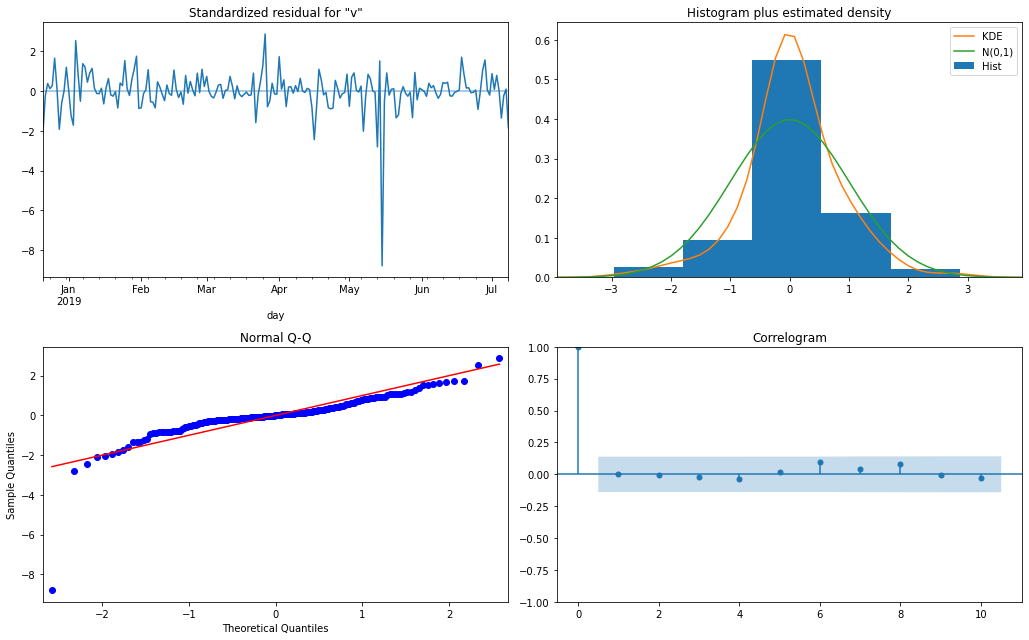

In [507]:
import matplotlib as mpl
with mpl.rc_context():
    mpl.rc("figure", figsize=(9*1.6,9))
    res.plot_diagnostics()
    plt.tight_layout()

In [508]:
v_hat = res.predict(DM.v.iloc[200:].index.min(), DM.v.iloc[200:].index.max(), exog=DM.gX.iloc[200:]); v_hat

2019-07-06    0.002969
2019-07-07   -0.001147
2019-07-08   -0.002722
2019-07-09    0.004982
2019-07-10   -0.002197
                ...   
2019-12-14    0.002596
2019-12-15    0.000913
2019-12-16   -0.002108
2019-12-17   -0.000097
2019-12-18    0.000384
Freq: D, Name: predicted_mean, Length: 166, dtype: float64

In [509]:
y0 = DM.y.iloc[199:200]; y0

y_hat = f.inv(v_hat, y0=DM.y.iloc[199:200], idx=v_hat.index)

day
2019-07-05    75.75
Freq: D, Name: y, dtype: float64

In [511]:
y_hat

2019-07-06    75.750000
2019-07-07    75.663102
2019-07-08    75.457138
2019-07-09    75.833041
2019-07-10    75.666409
                ...    
2019-12-14    75.416052
2019-12-15    75.484878
2019-12-16    75.325728
2019-12-17    75.318390
2019-12-18    75.347310
Freq: D, Name: y_hat, Length: 166, dtype: float64

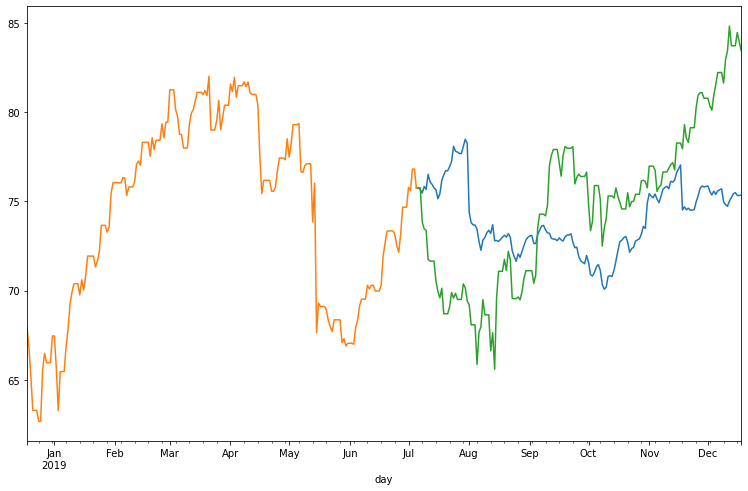

In [512]:
fig, ax = plt.subplots(figsize=figsize)
y_hat[y0.index.max()]=y0[y0.index.max()]
y_hat.sort_index(inplace=True)
y_hat.plot(ax=ax)
y[:200].plot(ax=ax)
y[200:].plot(ax=ax)
plt.show()

In [513]:
stb.metrics.mean_absolute_percentage_error(y_hat.loc[y[200:].index], y[200:])*100

5.4317206088331496

***

In [30]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3)

splits = [(train_idx, test_idx)for train_idx, test_idx in tscv.split(DM.dm.index)]

In [545]:
[(len(splits[i][0]), len(splits[i][1])) for i in range(len(splits))]

[(93, 90), (183, 90), (273, 90)]

In [547]:
len(DM.dm.index)

363

In [553]:
363-90-183

90

In [548]:
273+90

363

In [549]:
splits[0][0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92])

In [551]:
splits[2][0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
X = DM['google'].sort_index().squeeze()
fig, axs = plt.subplots(3,3, figsize=(9*1.6,9))
i=j=0
splits=[]
for train_index, test_index in tscv.split(X):      
    X_train, X_test = X[train_index].resample('1D').mean(), X[test_index].resample('1D').mean()
    X_train.plot(ax=axs[i,j], label='train')
    X_test.plot(ax=axs[i,j], label='test')
    splits.append((X_train,X_test))
    axs[i,j].legend()        
    j+=1
    if j%3==0:
        i+=1
        j=0
plt.tight_layout()
plt.show()

In [514]:
DM.dm

,v,g0,g1,g2
day,,,,
2018-12-21,-0.029146,-0.016935,6.010010,-0.040923
2018-12-22,0.000000,0.000000,0.000000,-0.025392
2018-12-23,0.000000,0.000000,0.000000,-0.016366
2018-12-24,-0.009796,-0.016949,-9.210022,-0.025749
2018-12-25,0.000000,0.000000,0.000000,-0.025749
...,...,...,...,...
2019-12-14,0.000000,0.000000,0.000000,0.016817
2019-12-15,0.000000,0.000000,0.000000,0.004410
2019-12-16,0.008840,0.013082,-5.540009,0.000579


In [555]:
C = sm.tsa.arima.ARIMA

In [84]:
cf = sm.tsa.arima.ARIMA

In [85]:
import inspect

In [86]:
cf = sm.Logit

In [87]:
inspect.signature(cf.predict)

<Signature (self, params, exog=None, linear=False)>

In [75]:
fitted = cv.calibrator.fit()

In [24]:
metric = stb.metrics.mean_absolute_percentage_error

In [96]:
from enum import Enum

In [137]:
DM.dm

,y,v,g0,g1,g2
day,,,,,
2018-12-21,63.290001,-0.029146,-0.016935,6.010010,-0.040923
2018-12-22,63.290001,0.000000,0.000000,0.000000,-0.025392
2018-12-23,63.290001,0.000000,0.000000,0.000000,-0.016366
2018-12-24,62.669998,-0.009796,-0.016949,-9.210022,-0.025749
2018-12-25,62.669998,0.000000,0.000000,0.000000,-0.025749
...,...,...,...,...,...
2019-12-14,83.709999,0.000000,0.000000,0.000000,0.016817
2019-12-15,83.709999,0.000000,0.000000,0.000000,0.004410
2019-12-16,84.449997,0.008840,0.013082,-5.540009,0.000579


In [138]:
DM.dm_ext

,y,v,ABC,ABMD,ABT,g0,g1,g2
day,,,,,,,,
2018-12-18,67.989998,NaN,76.239998,304.799988,70.080002,NaN,NaN,NaN
2018-12-19,66.830002,-0.017061,76.309998,296.140015,69.000000,0.000918,-8.659973,NaN
2018-12-20,65.190002,-0.024540,73.220001,284.279999,68.379997,-0.040493,-11.860016,NaN
2018-12-21,63.290001,-0.029146,71.980003,290.290009,67.269997,-0.016935,6.010010,-0.040923
2018-12-22,63.290001,0.000000,71.980003,290.290009,67.269997,0.000000,0.000000,-0.025392
...,...,...,...,...,...,...,...,...
2019-12-14,83.709999,0.000000,84.849998,181.850006,86.349998,0.000000,0.000000,0.016817
2019-12-15,83.709999,0.000000,84.849998,181.850006,86.349998,0.000000,0.000000,0.004410
2019-12-16,84.449997,0.008840,85.959999,176.309998,86.400002,0.013082,-5.540009,0.000579


In [107]:
class CalibType(Enum):
    sm = 'statsmodels'
    sk = 'sklearn'
        
class GeneralCalibrator:    
    def __init__(self, cf, kwargs=None):
        self.cf = cf
        self.kwargs = kwargs
        if 'sklearn' in cf.__module__:
            self.calib_type = CalibType.sk
        elif 'statsmodels' in cf.__module__:
            self.calib_type = CalibType.sm
        else:
            raise NotImplementedError(f'calibrator from package {cf.__module__} not accomodated yet')
    
    

In [182]:
class GeneralModel:
    def __init__(self, gc, DM):
        self.gc = gc
        self.DM = DM
        self.calibrator = None
        self.fitted = None
        self.v_hat = None
        
    def exog(self, idx):
        return DM.gX.iloc[idx] if DM.gX is not None else None
    
    def endog(self, idx):
        return DM.dm.v.iloc[idx]
    
    def fit(self, idx, **kwargs):
        if self.gc.calib_type is CalibType.sm:
            self.calibrator = self.gc.cf(endog = self.endog(idx), 
                                         exog = self.exog(idx), 
                                         **self.gc.kwargs)
            self.fitted = self.calibrator.fit(**kwargs)
    
    def forecast(self,idx):
        if 'start' in inspect.signature(gm.fitted.predict).parameters:
            self.v_hat = fitted.predict(
                          self.endog(idx).index.min(), 
                          self.endog(idx).index.max(),
                          exog=self.exog(idx))
        else:
            self.v_hat = fitted.predict(exog=self.exog(idx))



In [183]:
gm = GeneralModel(gc, DM)

In [184]:
gm.fit(range(15))

In [185]:
gm.fit(range(15))

In [186]:
gm.forecast(range(15,30))

In [ ]:
class CrossValidation:
    def __init__(self, gc, DM, splits, metric):
        self.gc = gc
        self.DM = DM
        self.splits = splits
        self.metric = metric
       
    def run(self):
        metric_list = []
        for train_index, test_index in splits:
            if self.gc.calib_type is CalibType.sm:
                exog = DM.gX.iloc[train_index] if DM.gX is not None else None
                calibrator = self.gc.cf(endog = DM.dm.v.iloc[train_index], 
                                        exog = exog, 
                                        **self.gc.kwargs)
                fitted = calibrator.fit()
            print(inspect.signature(fitted.predict))
            exog = DM.gX.iloc[test_index] if DM.gX is not None else None
            try:
                v_hat = fitted.predict(
                              DM.dm.v.iloc[test_index].index.min(), 
                              DM.dm.v.iloc[test_index].index.max(),
                              exog=exog)
            except:
                v_hat = fitted.predict(
                              exog=exog)
            
            
            y0 = DM.dm.y.iloc[train_index].tail(DM.f.n)
            y_hat = f.inv(v_hat, y0=y0, idx=v_hat.index)
            y = DM.dm.y.iloc[test_index]
            metric_val = metric(y, y_hat)
            metric_list.append(metric_val)

            fig, ax = plt.subplots(figsize=figsize)
            y_hat.at[y0.index.max()] = y0[y0.index.max()]
            y_hat.sort_index(inplace=True)
            y_hat.plot(ax=ax)
            ax.set_title(f'Metric = {metric_val:.4f}')
            y.plot(ax=ax)
        

        CV_error = np.mean(metric_list)
        CV_std =  np.std(metric_list)
        print(f'CV_error: {CV_error:.4f} +/- {CV_std:.4f}')
        plt.show()
        
        return CV_error, CV_std

In [126]:
class CrossValidation:
    def __init__(self, gc, DM, splits, metric):
        self.gc = gc
        self.DM = DM
        self.splits = splits
        self.metric = metric
       
    def run(self):
        metric_list = []
        for train_index, test_index in splits:
            if self.gc.calib_type is CalibType.sm:
                exog = DM.gX.iloc[train_index] if DM.gX is not None else None
                calibrator = self.gc.cf(endog = DM.dm.v.iloc[train_index], 
                                        exog = exog, 
                                        **self.gc.kwargs)
                fitted = calibrator.fit()
            print(inspect.signature(fitted.predict))
            exog = DM.gX.iloc[test_index] if DM.gX is not None else None
            try:
                v_hat = fitted.predict(
                              DM.dm.v.iloc[test_index].index.min(), 
                              DM.dm.v.iloc[test_index].index.max(),
                              exog=exog)
            except:
                v_hat = fitted.predict(
                              exog=exog)
            
            
            y0 = DM.dm.y.iloc[train_index].tail(DM.f.n)
            y_hat = f.inv(v_hat, y0=y0, idx=v_hat.index)
            y = DM.dm.y.iloc[test_index]
            metric_val = metric(y, y_hat)
            metric_list.append(metric_val)

            fig, ax = plt.subplots(figsize=figsize)
            y_hat.at[y0.index.max()] = y0[y0.index.max()]
            y_hat.sort_index(inplace=True)
            y_hat.plot(ax=ax)
            ax.set_title(f'Metric = {metric_val:.4f}')
            y.plot(ax=ax)
        

        CV_error = np.mean(metric_list)
        CV_std =  np.std(metric_list)
        print(f'CV_error: {CV_error:.4f} +/- {CV_std:.4f}')
        plt.show()
        
        return CV_error, CV_std

In [127]:
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3)

splits = [(train_idx, test_idx)for train_idx, test_idx in tscv.split(DM.dm.index)]

(start=None, end=None, dynamic=False, **kwargs)
(start=None, end=None, dynamic=False, **kwargs)
(start=None, end=None, dynamic=False, **kwargs)
CV_error: 0.0504 +/- 0.0185


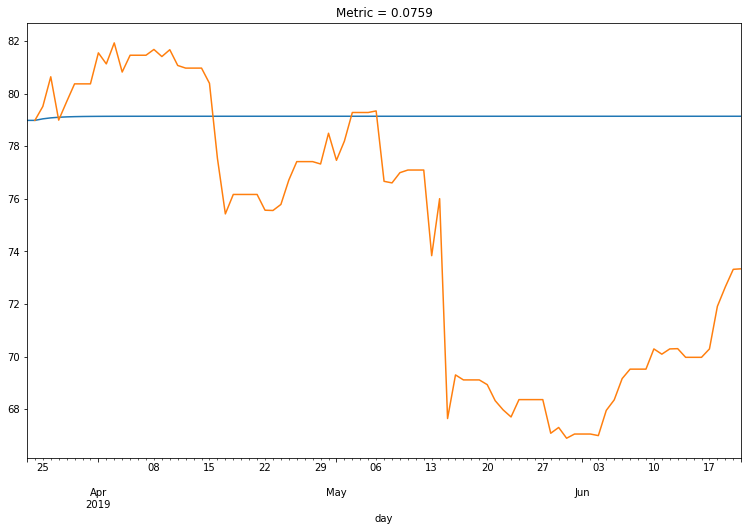

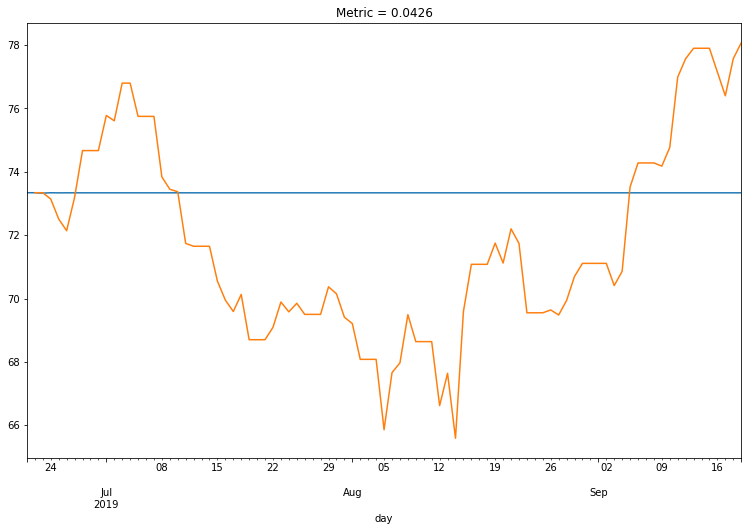

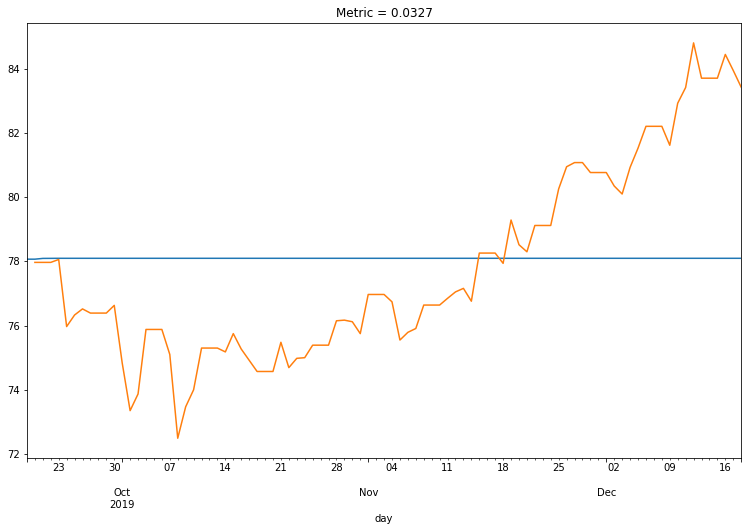

In [134]:
gc = GeneralCalibrator(sm.tsa.arima.ARIMA, 
                            dict(order=(2,0,1), 
                            trend='n', 
                            enforce_stationarity=True))

cv = CrossValidation(gc, DM, splits, metric)
cv_error, cv_std = cv.run()

In [123]:
metric

<function statslib._lib.metrics.mean_absolute_percentage_error(y_true, y_pred)>

In [124]:
gc = GeneralCalibrator(sm.OLS, dict())
cv = CrossValidation(gc, DM, splits, metric)

cv.run()

AttributeError: 'NoneType' object has no attribute 'shape'

In [651]:
f

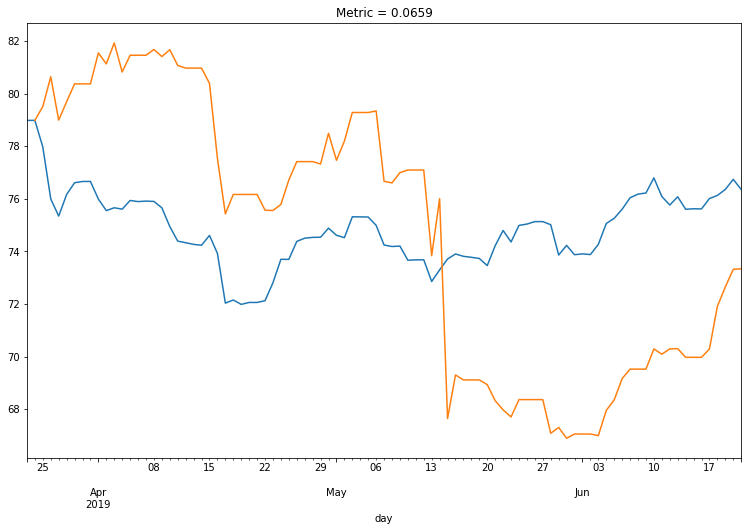

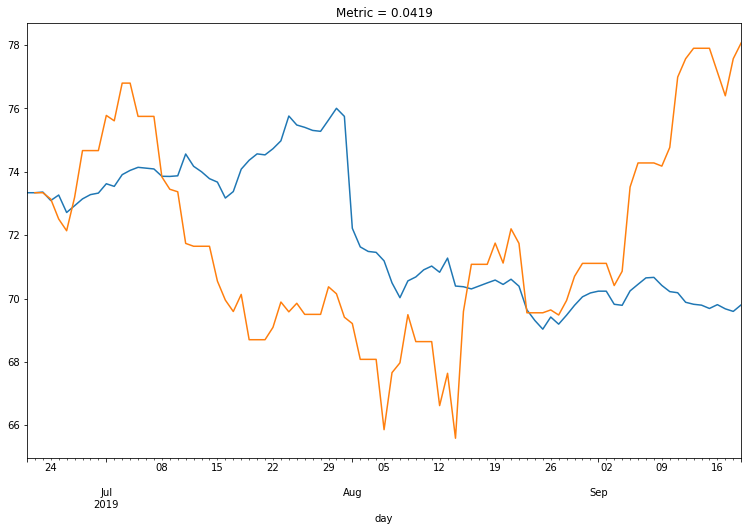

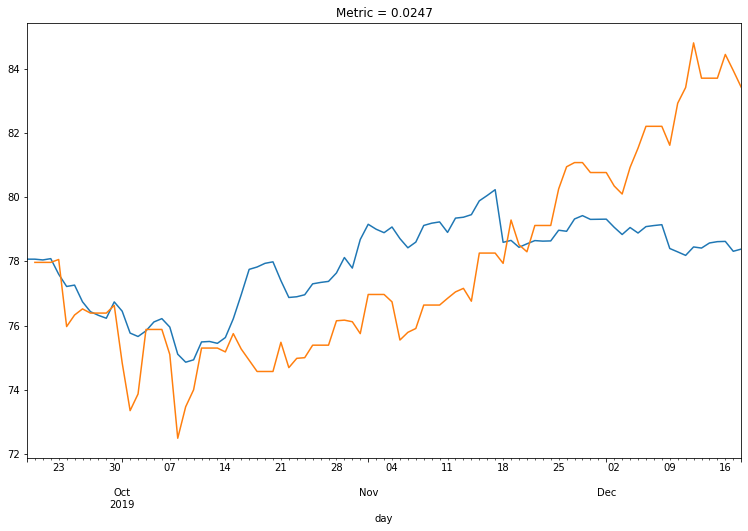

CV_error: 0.0441 +/- 0.0169


0.04414980372875976

In [744]:
y0

day
2019-03-23    78.989998
Freq: D, Name: y, dtype: float64

In [745]:
y_hat.head()

2019-03-24    78.989998
2019-03-25    77.974436
2019-03-26    75.998207
2019-03-27    75.347455
2019-03-28    76.168855
Freq: D, Name: y_hat, dtype: float64

In [747]:
y_hat[y0.index.max()]=

In [750]:
y_hat.at[y0.index.max()] = y0[y0.index.max()]

In [715]:
y0a

day
2019-03-20    80.919998
Freq: D, Name: y, dtype: float64

In [711]:
y_hat

2019-03-24    80.919998
2019-03-25    79.879623
2019-03-26    77.855107
2019-03-27    77.188455
2019-03-28    78.029925
                ...    
2019-06-17    77.871395
2019-06-18    77.993301
2019-06-19    78.227353
2019-06-20    78.620071
2019-06-21    78.227236
Freq: D, Name: y_hat, Length: 90, dtype: float64

In [698]:
y0

day
2019-03-20    80.919998
Freq: D, Name: y, dtype: float64

In [704]:
train_index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92])

In [705]:
test_index

array([ 93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182])

In [706]:
DM.dm.v.iloc[train_index].index

DatetimeIndex(['2018-12-21', '2018-12-22', '2018-12-23', '2018-12-24',
               '2018-12-25', '2018-12-26', '2018-12-27', '2018-12-28',
               '2018-12-29', '2018-12-30', '2018-12-31', '2019-01-01',
               '2019-01-02', '2019-01-03', '2019-01-04', '2019-01-05',
               '2019-01-06', '2019-01-07', '2019-01-08', '2019-01-09',
               '2019-01-10', '2019-01-11', '2019-01-12', '2019-01-13',
               '2019-01-14', '2019-01-15', '2019-01-16', '2019-01-17',
               '2019-01-18', '2019-01-19', '2019-01-20', '2019-01-21',
               '2019-01-22', '2019-01-23', '2019-01-24', '2019-01-25',
               '2019-01-26', '2019-01-27', '2019-01-28', '2019-01-29',
               '2019-01-30', '2019-01-31', '2019-02-01', '2019-02-02',
               '2019-02-03', '2019-02-04', '2019-02-05', '2019-02-06',
               '2019-02-07', '2019-02-08', '2019-02-09', '2019-02-10',
               '2019-02-11', '2019-02-12', '2019-02-13', '2019-02-14',
      

In [707]:
DM.dm.v.iloc[test_index].index

DatetimeIndex(['2019-03-24', '2019-03-25', '2019-03-26', '2019-03-27',
               '2019-03-28', '2019-03-29', '2019-03-30', '2019-03-31',
               '2019-04-01', '2019-04-02', '2019-04-03', '2019-04-04',
               '2019-04-05', '2019-04-06', '2019-04-07', '2019-04-08',
               '2019-04-09', '2019-04-10', '2019-04-11', '2019-04-12',
               '2019-04-13', '2019-04-14', '2019-04-15', '2019-04-16',
               '2019-04-17', '2019-04-18', '2019-04-19', '2019-04-20',
               '2019-04-21', '2019-04-22', '2019-04-23', '2019-04-24',
               '2019-04-25', '2019-04-26', '2019-04-27', '2019-04-28',
               '2019-04-29', '2019-04-30', '2019-05-01', '2019-05-02',
               '2019-05-03', '2019-05-04', '2019-05-05', '2019-05-06',
               '2019-05-07', '2019-05-08', '2019-05-09', '2019-05-10',
               '2019-05-11', '2019-05-12', '2019-05-13', '2019-05-14',
               '2019-05-15', '2019-05-16', '2019-05-17', '2019-05-18',
      

In [700]:
ddff(DM.dm_ext)

,y,v,ABC,ABMD,ABT,g0,g1,g2
day,,,,,,,,
2018-12-18,67.989998,NaN,76.239998,304.799988,70.080002,NaN,NaN,NaN
2018-12-19,66.830002,-0.017061,76.309998,296.140015,69.000000,0.000918,-8.659973,NaN
2018-12-20,65.190002,-0.024540,73.220001,284.279999,68.379997,-0.040493,-11.860016,NaN
2018-12-21,63.290001,-0.029146,71.980003,290.290009,67.269997,-0.016935,6.010010,-0.040923
2018-12-22,63.290001,0.000000,71.980003,290.290009,67.269997,0.000000,0.000000,-0.025392
2018-12-23,63.290001,0.000000,71.980003,290.290009,67.269997,0.000000,0.000000,-0.016366
2018-12-24,62.669998,-0.009796,70.760002,281.079987,65.559998,-0.016949,-9.210022,-0.025749
2018-12-25,62.669998,0.000000,70.760002,281.079987,65.559998,0.000000,0.000000,-0.025749
2018-12-26,65.540001,0.045795,73.040001,307.440002,69.620003,0.032222,26.360016,0.034338


In [694]:
y_hat

2019-03-24    80.919998
2019-03-25    79.879623
2019-03-26    77.855107
2019-03-27    77.188455
2019-03-28    78.029925
                ...    
2019-06-17    77.871395
2019-06-18    77.993301
2019-06-19    78.227353
2019-06-20    78.620071
2019-06-21    78.227236
Freq: D, Name: y_hat, Length: 90, dtype: float64

In [ ]:
v_hat = res.predict(DM.v.iloc[200:].index.min(), DM.v.iloc[200:].index.max(), exog=DM.gX.iloc[200:]); v_hat

In [594]:
cv.calib_type

'sklearn'

In [581]:
pa = stb.utils.common.print_attributes

In [582]:
cf

statsmodels.tsa.arima.model.ARIMA

In [583]:
from sklearn.linear_model import LinearRegression

In [584]:
LinearRegression.__module__

'sklearn.linear_model._base'

In [585]:
cf.__module__

'statsmodels.tsa.arima.model'